In [1]:
import torch
from torch import nn

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from trainer import Trainer,  generate_data_iter
import utils, cam, attack
import os
from tqdm import trange

class_names = {
    'Imagenette': (
        'Tench', 'English Springer', 'Cassette Player', 'Chain Saw', 'Church', 
        'French Horn', 'Garbage Truck', 'Gas Pump', 'Golf Ball', 'Parachute'
    ),
    'CIFAR10': (
        'Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse',
        'Ship', 'Trunk'
    ),
    'FashionMNIST': (
        'T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt',
        'Sneaker', 'Bag', 'Ankle boot'
    )
}

In [2]:
def load_pics(attack_name, model_mode, dataset, idx = 0):
    seed, model_mode = 2, str.lower(model_mode)
    utils.set_random_seed(seed)
    trainer = Trainer(
        model_mode = model_mode,
        dataset = dataset,
        bs = 128,
        lr = 0.01,
        seed = seed,
        cuda = 3,
        use_lr_sche = True,
        use_wandb = False,
    )
    trainer.load()
    
    data_iter = generate_data_iter(dataset, 100, 'test')
    raw_imgs, labels = next(iter(data_iter))
    
    suc_indices = np.load(f'./thesis/attack/indices/{dataset}/suc-{dataset}-{model_mode}-seed0.npy')
    att_indices = np.load(f'./thesis/attack/indices/{dataset}/{attack_name}-{dataset}-{model_mode}-seed{seed}.npy')
    
    suc_imgs = raw_imgs[suc_indices][att_indices]
    target_layer = 'layer4' if model_mode == 'resnet18' else 'features'
    scorecam = cam.ScoreCAM(trainer.model, dataset, target_layer, cuda = 3)
    raw_cam_img, raw_pred, raw_prob, _ = scorecam(suc_imgs[idx].unsqueeze(0))
    raw_img = np.transpose(suc_imgs[idx].numpy(), (1, 2, 0))

    att_img = np.load(
        f'./thesis/attack/attack_pics/{dataset}/{attack_name}-{dataset}-{model_mode}-seed{seed}.npy'
    )[att_indices][idx]
    att_cam_img, att_pred, att_prob, _ = scorecam(torch.from_numpy(att_img).unsqueeze(0))
    att_img = np.transpose(att_img, (1, 2, 0))
    
    raw = (raw_img, raw_cam_img[0], raw_pred[0], raw_prob[0])
    att = (att_img, att_cam_img[0], att_pred[0], att_prob[0])
    return raw, att

def draw_att_pic(att_name, indices = [0, 0, 0, 0], single_figsize = 5):
    settings = [
        ['ResNet18',        'FashionMNIST',     indices[0]],
        ['ResNet18',        'CIFAR10',          indices[1]],
        ['ResNet18',        'Imagenette',       indices[2]],
        ['DenseNet121',     'Imagenette',       indices[3]],
    ]
    
    fontsize = 25
    figure = plt.figure(figsize = (4 * single_figsize, 4 * single_figsize))
    for i in range(len(settings)):
        model_mode, dataset = settings[i][0], settings[i][1]
        raw, att = load_pics(att_name, *settings[i])
        
        plt.subplot(4, 4, i + 1)
        plt.imshow(raw[0])
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.ylabel('Raw Image', fontsize = fontsize)
        plt.title(f'{dataset}\n({model_mode})', fontsize = fontsize)
        plt.xlabel(f'{class_names[dataset][raw[2]]} ({raw[3] * 100:4.2f})%', fontsize = fontsize)
        
        plt.subplot(4, 4, i + 5)
        plt.imshow(att[0])
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.ylabel('Perturbed Image', fontsize = fontsize)
        plt.xlabel(f'{class_names[dataset][att[2]]} ({att[3] * 100:4.2f})%', fontsize = fontsize)
       
        
        plt.subplot(4, 4, i + 9)
        plt.imshow(raw[1])
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.ylabel('Raw Image Heatmap', fontsize = fontsize)
        # plt.title(f'{class_names[dataset][raw[2]]} ({raw[3] * 100:4.2f})%')
        
        plt.subplot(4, 4, i + 13)
        plt.imshow(att[1])
        plt.xticks([])
        plt.yticks([])
        if i == 0:
            plt.ylabel('Perturbed Image Heatmap', fontsize = fontsize)
        # plt.title(f'{class_names[dataset][att[2]]} ({att[3] * 100:4.2f})%')
    plt.tight_layout()
    
    pic_pth = './thesis/pics/'
    png_pth, svg_pth = pic_pth + 'png/', pic_pth + 'svg/'
    pths = [png_pth, svg_pth]
    for pth in pths:
        if not os.path.exists(pth):
            os.makedirs(pth)
            
    plt.savefig(png_pth + att_name + '.png', bbox_inches = 'tight', pad_inches = 0.03)
    plt.savefig(svg_pth + att_name + '.svg', bbox_inches = 'tight', pad_inches = 0.03)

In [ ]:
attacks = [
    'FGSM', 'FGM', 'StepLL', 
    'IFGSM', 'MIFGSM', 'NIFGSM', 'IterLL', 'PGD',
    'DeepFool', 'LBFGS', 'CW', 'UniPerturb'
]

with trange(len(attacks)) as t:
    for i in t:
        draw_att_pic(attacks[i], [1, 1, 1, 1])    

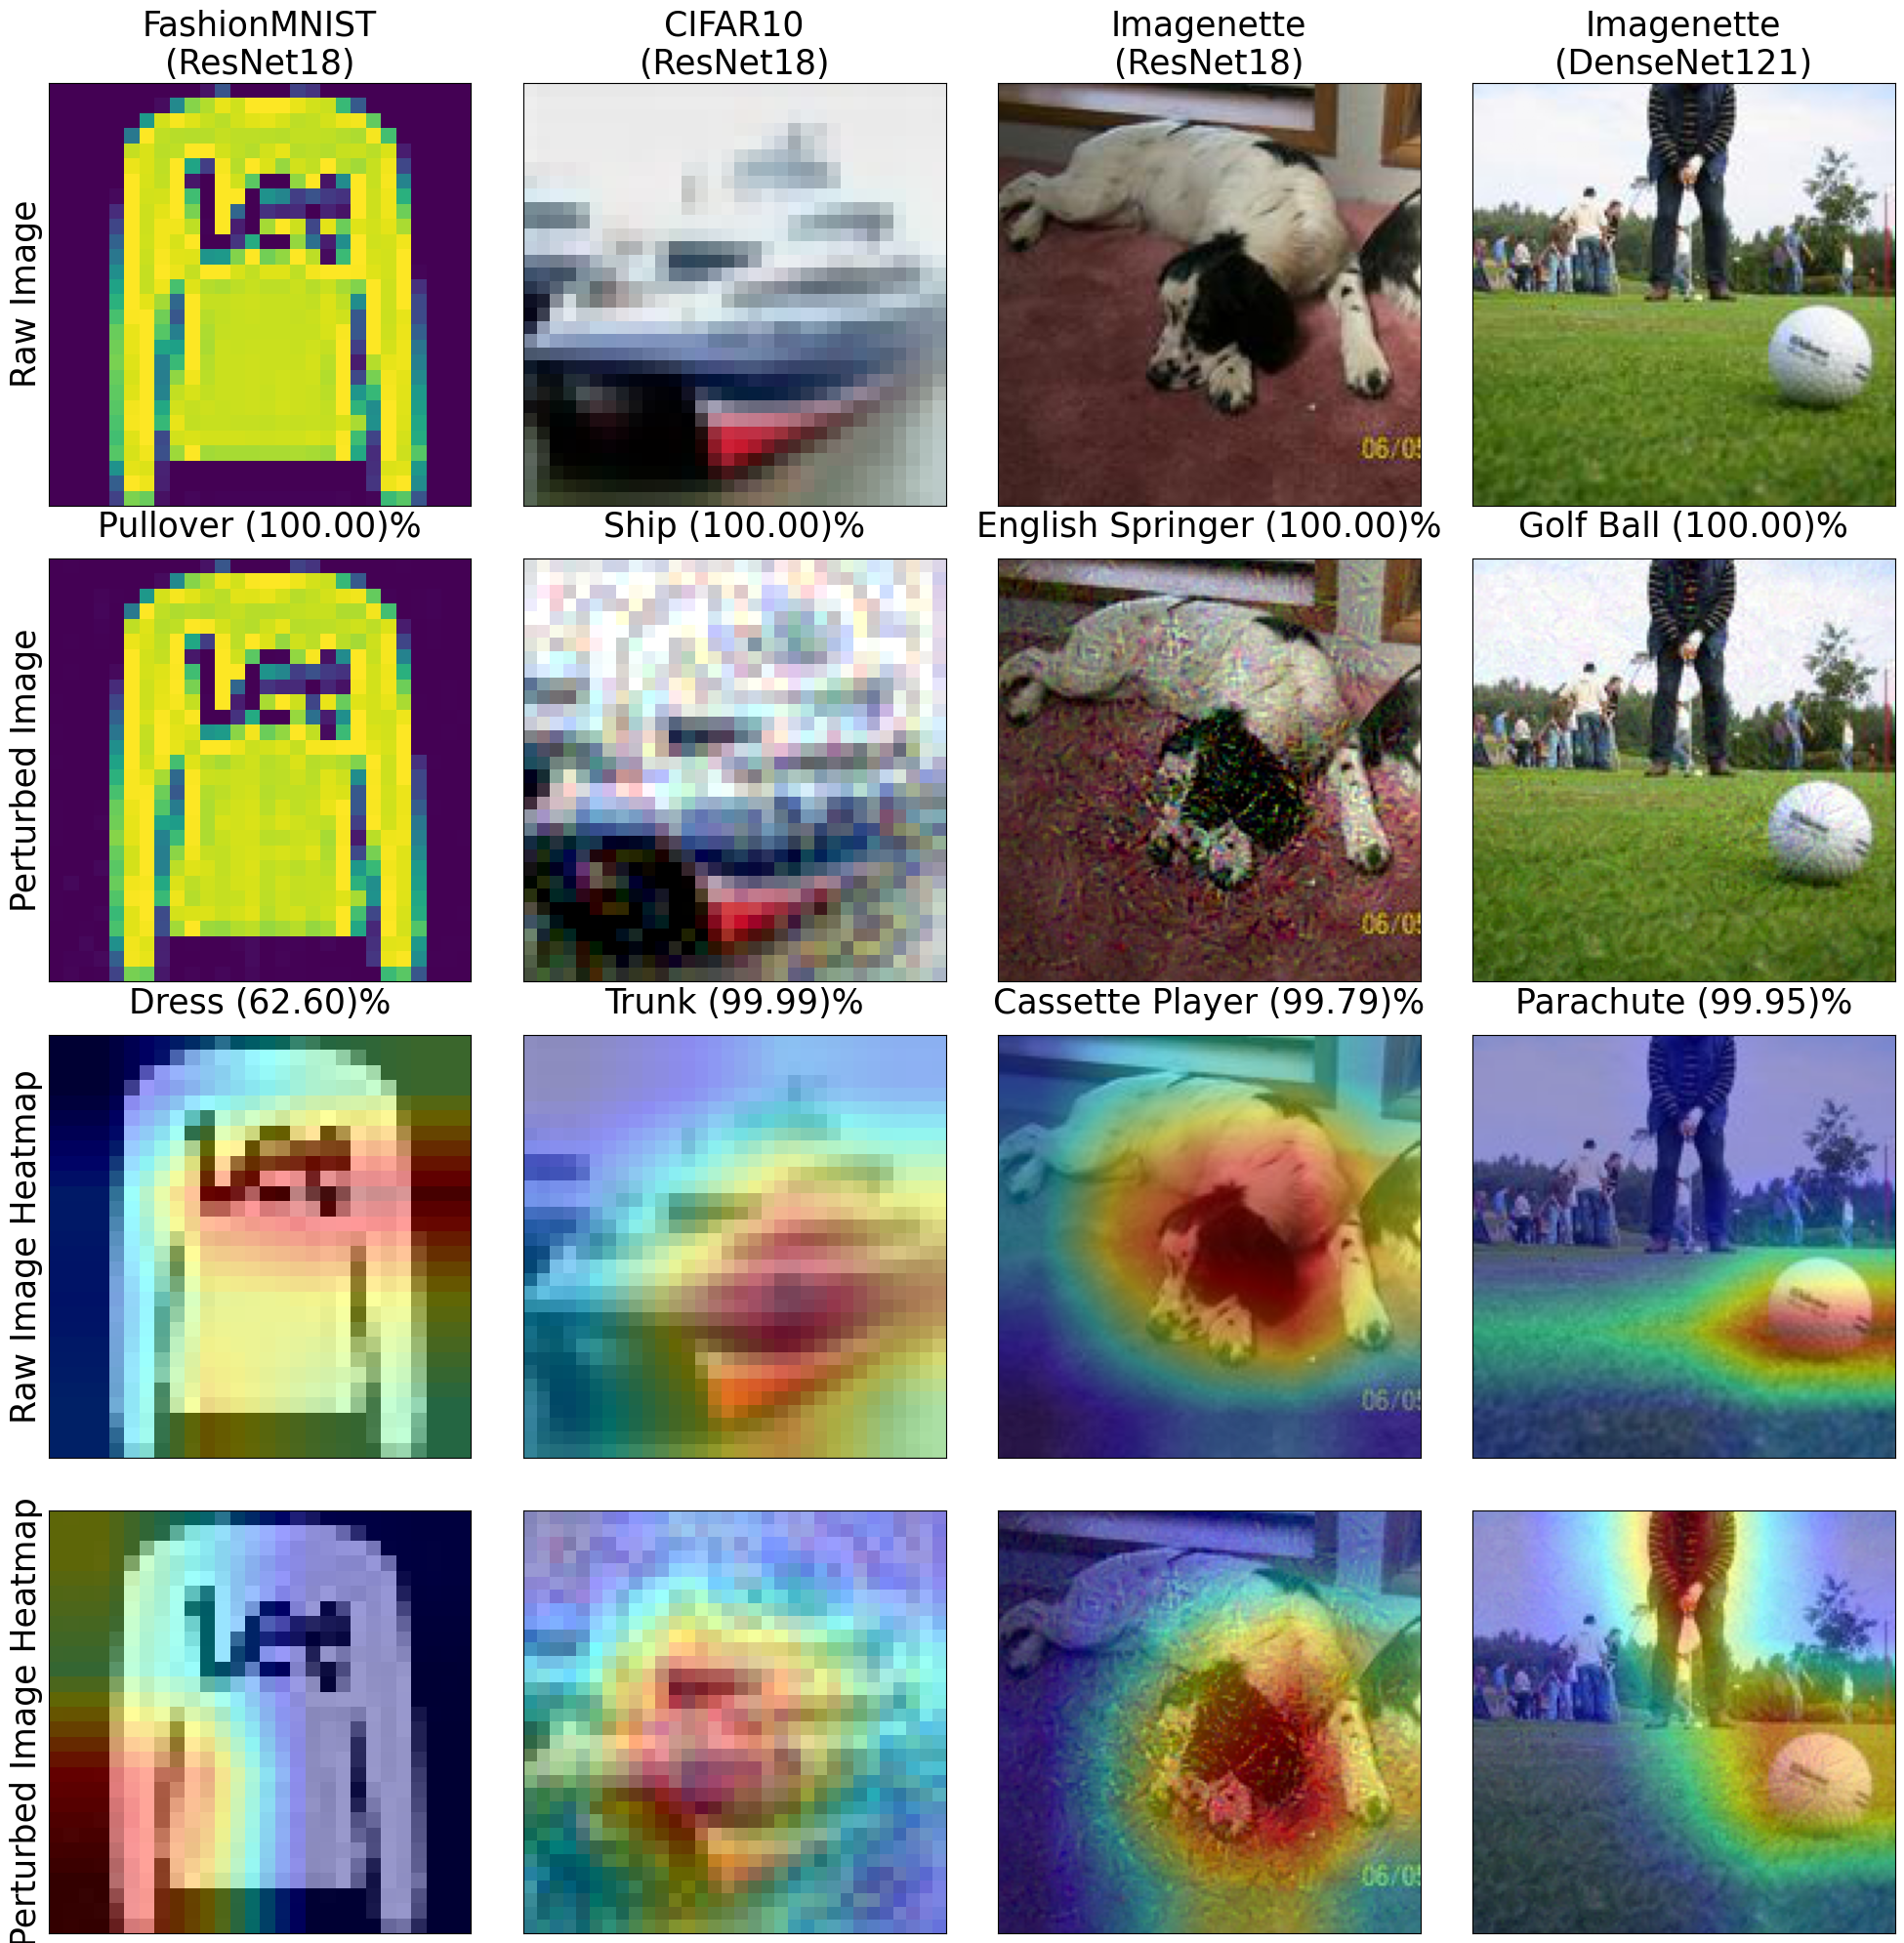

In [3]:
draw_att_pic('CW', [1, 1, 1, 1])